In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import json
import itertools
import re
import random

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import chart_studio.plotly as py
import plotly.graph_objs as go

from datetime import date, timedelta
from skimage.draw import ellipse
from textwrap import wrap
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import HTML, Image
from plotly import tools
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

plt.style.use('seaborn-white')
%matplotlib inline
init_notebook_mode(connected=True)

In [2]:
# read csv file
# 12 columns that should be in database 
columns = ['video_id', 'title', 'channel_title', 'category_id',
          'tags', 'views', 'likes', 'dislikes', 'comment_count',
          'thumbnail_link']

gb_vid_df =  pd.read_csv("GBvideos.csv", usecols = columns)
us_vid_df =  pd.read_csv("USvideos.csv", usecols = columns)




In [4]:


# remove duplicates for GB videos database
gb_vid_df = gb_vid_df.drop_duplicates()
us_vid_df = us_vid_df.drop_duplicates()

gb_vid_df.head(5)

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_count,thumbnail_link
0,Jw1Y-zhQURU,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg
1,3s1rvMFUweQ,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,24,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg
2,n1WpP7iowLc,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg
3,PUTEiSjKwJU,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,17,"Salford City FC|""Salford City""|""Salford""|""Clas...",27833,193,12,37,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg
4,rHwDegptbI4,Dashcam captures truck's near miss with child ...,Cute Girl Videos,25,[none],9815,30,2,30,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg


In [5]:
# dataframe to see videos per each date
def quick_insight(df, country, color):
    # dataframes for videos per each date
    vid_check = df[['video_id', 'date']].copy().groupby('date', as_index = False).count()
    vid_check.columns = ['Dates', 'Videos per date']
    
    # dataframes for 
    dates_per_id = df[['video_id', 'date']].groupby('video_id', as_index = False).count()
    dates_per_vids = dates_per_id.groupby('date', as_index = False).count()
    dates_per_vids.columns = ['Quantity of dates per video', 'Quantity of videos in a date group']
    max_days = max(dates_per_vids['Quantity of dates per video'].values)
    
    # videos appeared in database as at 13 September 2017
    sept_13_id = df.loc[df['date'] == date(2017,9,13), 'video_id'].tolist()
    sept_13 = df.loc[df['video_id'].isin(sept_13_id), ['video_id', 'date']]
    sept_13 = sept_13.groupby('date', as_index=False).count()   
    
    # combined plot
    fig = plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(3, 2, width_ratios=[1,1], height_ratios = [1,0.1,1])
    
    # plotting videos per each date
    ax1 = plt.subplot(gs[2,0:2])
    ax1 = sns.barplot(x="Dates", y="Videos per date", data=vid_check, color='green', alpha=0.8)
    ax1.set_ylabel('Videos per date', fontsize=12)
    ax1.set_xticklabels(vid_check['Dates'].unique(), rotation=45)
    ax1.set_xlabel('')
    ax1.set_title('Videos per each date ({})'.format(country), fontsize=15)
    
    # plotting buckets of videos by quantity of trending dates
    ax2 = plt.subplot(gs[0,0])
    ax2 = sns.barplot(x="Quantity of dates per video",
                      y="Quantity of videos in a date group",
                      data=dates_per_vids, color=color)
    ax2.set_ylabel('Quantity of videos in a date group', fontsize=12)
    ax2.set_xlabel('Quantity of trending days in a bucket', fontsize=12)
    t_str = u'Buckets of videos by quantity of trending dates ({})'
    title = '\n'.join(wrap(t_str.format(country),30))
    ax2.set_title(title, fontsize=15)
    
    # plotting story of videos that appeared on September 13
    ax3 = plt.subplot(gs[0,1])    
    ax3 = sns.barplot(x='date', y="video_id", data=sept_13, color=color, alpha = 0.7)
    ax3.set_ylabel('Quantity of videos per date', fontsize=12)
    ax3.set_xticklabels(sept_13['date'], rotation=45)
    ax3.set_xlabel('')
    t_str = u'Videos started at 13 September ({})'
    title = '\n'.join(wrap(t_str.format(country),20))
    ax3.set_title(title, fontsize=15)
    
    plt.show()

In [11]:
# function for channels analysis
# days_a must be in range between day_start and day_end
def channels_insight(df, country, day_start, day_end, days_a):
    # list of selected dates
    datelist = [day_start + timedelta(days=x) for x in range((day_end-day_start).days + 1)]
    # take part of database that included in relevant period
    df = df.copy().loc[df['date'].isin(datelist),]
    # make list of channels survived for selected days_a
    df_ch_days = df.groupby('channel_title')['date'].nunique().to_frame().reset_index()
    df_ch_list = df_ch_days.loc[df_ch_days['date']==days_a, 'channel_title'].unique().tolist()
    
    # plotting videos per each channel (by views)
    data = []
    buttons = []
    buttons_list = []
    
    for x in df_ch_list:
        channel_videos = df.loc[df['channel_title'] == x,['title', 'date', 'views']]
        videos_list = channel_videos['title'].unique().tolist()
        boolean_list = [True] + [False]*(len(videos_list)-1)
        color = 'rgb('+str(np.random.randint(1,256))+","+str(np.random.randint(1,256))+","+str(np.random.randint(1,256))+")"
        for i in range(0,len(videos_list)):
            vt = videos_list[i]
            video = channel_videos.loc[channel_videos['title']==vt, ['views', 'date']]
            trace = go.Scatter(x = video['date'].values,
                               y = video['views'].values,
                               name = x,
                               line = dict(width = 2, color = color),
                               legendgroup = x,
                               showlegend = boolean_list[i])
            buttons_list.append(x) # this list will help identify buttons visibility
            data.extend([trace])
    
    for x in df_ch_list:       
        buttons_upd = list([dict(label = x,
                                method = 'update',
                                args = [{'visible': [i==x for i in buttons_list]}])])
        buttons.extend(buttons_upd)
    
    buttons_all = list([dict(label = 'All channels',
                             method = 'update',
                             args = [{'visible': [True for x in buttons_list]}])]) 

    buttons.extend(buttons_all)
    
    update_menus = list([dict(active=1,
                              buttons = buttons,
                              direction = 'down',
                              pad = {'r': 10, 't': 10},
                              showactive = True,
                              x = 0.001,
                              xanchor = 'left',
                              y = 1.1,
                              yanchor = 'top')])
    
    layout = dict(title = 'Videos of trending channels ({})'.format(country),
                  xaxis = dict(title = ''),
                  yaxis = dict(title = 'views'),
                  updatemenus = update_menus,
                  width=800, height=600, legend=dict(orientation="h"))
         
    fig = dict(data = data, layout = layout)
    
    iplot(fig)

In [14]:
# dictionary for GB database
with open('GB_category_id.json') as json_data:
    gb_from_json = json.load(json_data)
gb_prelim_dict = gb_from_json['items']
json_data.close()

gb_cat_dict = {}
for i in range (0,len(gb_prelim_dict)):
    cat_key = int(gb_prelim_dict[i]['id'])
    cat_item = gb_prelim_dict[i]['snippet']['title']
    gb_cat_dict[cat_key] = cat_item
gb_cat_dict[29] = 'Schools & Hospitals'
    
# dictionary for US database
with open('GB_category_id.json') as json_data:
    us_from_json = json.load(json_data)
us_prelim_dict = us_from_json['items']
json_data.close()

us_cat_dict = {}
for i in range (0,len(us_prelim_dict)):
    cat_key = int(us_prelim_dict[i]['id'])
    cat_item = us_prelim_dict[i]['snippet']['title']
    us_cat_dict[cat_key] = cat_item
gb_cat_dict[29] = 'Schools & Hospitals'

# addition of categories to both databases
gb_vid_df['category_name'] = gb_vid_df['category_id'].apply(lambda x: gb_cat_dict[x])
gb_vid_df.head(5)

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_count,thumbnail_link,category_name
0,Jw1Y-zhQURU,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,Howto & Style
1,3s1rvMFUweQ,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,24,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,Entertainment
2,n1WpP7iowLc,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,Music
3,PUTEiSjKwJU,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,17,"Salford City FC|""Salford City""|""Salford""|""Clas...",27833,193,12,37,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,Sports
4,rHwDegptbI4,Dashcam captures truck's near miss with child ...,Cute Girl Videos,25,[none],9815,30,2,30,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,News & Politics


In [15]:
gb_vid_df.rename(columns={'comment_total':'comments'}, inplace=True)
us_vid_df.rename(columns={'comment_total':'comments'}, inplace=True)

/Users/ismayiltahmazov/opt/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:1494: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



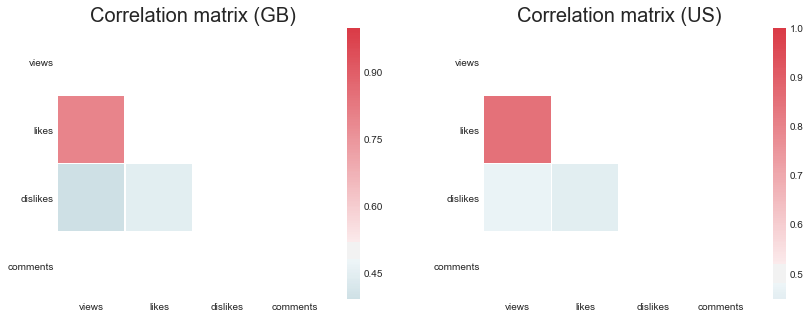

In [16]:
corr_gb = gb_vid_df.loc[:,['views', 'likes', 'dislikes', 'comments']].corr()
corr_us = us_vid_df.loc[:,['views', 'likes', 'dislikes', 'comments']].corr()

mask = np.zeros_like(corr_gb, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1])
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax1 = plt.subplot(gs[0,0])
ax1 = sns.heatmap(corr_gb, cmap=cmap, vmax=1, center=0.5,
            square=True, linewidths=.5, mask=mask)
ax1.set_title('Correlation matrix (GB)', fontsize=20)
plt.yticks(rotation=0)

ax2 = plt.subplot(gs[0,1])
ax1 = sns.heatmap(corr_us, cmap=cmap, vmax=1, center=0.5,
                  square=True, linewidths=.5, mask=mask)
ax2.set_title('Correlation matrix (US)', fontsize=20)
plt.yticks(rotation=0)

plt.show()

In [17]:
def vldc_plot(df_init, country):
    df = df_init[['date','views', 'likes',
             'dislikes','comments']].groupby('date', as_index = False).sum()
    df[['views','likes', 'dislikes','comments']] = df[['views', 'likes',
                                                       'dislikes', 'comments']].apply(lambda x: x/1000000)
    fig = plt.figure(figsize=(12, 5))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1,1])

    ax1 = plt.subplot(gs[0,0])
    ax1.plot(df['date'], df['views'])
    ax1.set_xticklabels("")
    ax1.set_title('Views, mln', fontsize=20)

    ax2 = plt.subplot(gs[0,1])
    ax2.plot(df['date'], df['comments'])
    ax2.set_xticklabels("")
    ax2.set_title('Comments, mln', fontsize=20)

    ax3 = plt.subplot(gs[1,0])
    ax3.plot(df['date'], df['likes'])
    ax3.set_xticks(df['date'].values)
    ax3.set_xticklabels(df['date'], rotation=45)
    ax3.set_title('Likes, mln', fontsize=20)

    ax4 = plt.subplot(gs[1,1])
    ax4.plot(df['date'], df['dislikes'])
    ax4.set_xticks(df['date'].values)
    ax4.set_xticklabels(df['date'], rotation=45)
    ax4.set_title('Dislikes, mln', fontsize=20)

    plt.suptitle('{} segment'.format(country), fontsize=22)

    plt.show()

The first step is to convert tags from string to list of strings.

In [20]:
gb_vid_df['tags'] = gb_vid_df['tags'].map(lambda x: x.split('|'))
us_vid_df['tags'] = us_vid_df['tags'].map(lambda x: x.split('|'))

There are few rows that have more collumns than they should. Due to insignificant amount it is safe to exclude them.

In [22]:
# downloading the data and skip bad rows
gb_comm_df =  pd.read_csv("GBcomments.csv", error_bad_lines = False)
us_comm_df =  pd.read_csv("UScomments.csv", error_bad_lines = False)

Skipping line 113225: expected 4 fields, saw 5

Skipping line 158379: expected 4 fields, saw 7
Skipping line 241590: expected 4 fields, saw 5
Skipping line 245637: expected 4 fields, saw 7

Skipping line 521402: expected 4 fields, saw 5

Skipping line 41589: expected 4 fields, saw 11
Skipping line 51628: expected 4 fields, saw 7
Skipping line 114465: expected 4 fields, saw 5

Skipping line 142496: expected 4 fields, saw 8
Skipping line 189732: expected 4 fields, saw 6
Skipping line 245218: expected 4 fields, saw 7

Skipping line 388430: expected 4 fields, saw 5

/Users/ismayiltahmazov/opt/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning:

Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.



In [24]:
# combined database on videos features (will be used for vlookup only)
all_vid_df = gb_vid_df.append(us_vid_df)

# leave only most recent date for each video
all_vid_df.drop_duplicates('video_id', keep = 'first', inplace = True)


# combined database for comments
all_comm_df = gb_comm_df.append(us_comm_df)
# duplicates should be deleted
all_comm_df.drop_duplicates(['video_id', 'comment_text'], keep = 'first', inplace = True)

all_comm_df = all_comm_df.join(all_vid_df.set_index('video_id')[['tags',
                                                               'channel_title',
                                                               'title']], on = 'video_id')
# make additional column for number of tags
all_comm_df['num_tags'] = all_comm_df['tags'].apply(lambda x: len(x))
all_comm_df.shape

TypeError: object of type 'float' has no len()

To make predictions I need to get rid of different artifacts (html characters and emojis) and exclude non-ASCII characters. Following functions should help with this task: 

In [ ]:
# function for cleaning urls
def remove_urls(x):
    return re.sub(r"http\S+", "", x)

In [ ]:
# function for cleaning text of html tags and uris

# thanks to https://www.kaggle.com/l3nnys/useful-text-preprocessing-on-the-datasets
uri_re = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'

def stripTagsAndUris(x):
    # BeautifulSoup on content
    soup = BeautifulSoup(x, "html.parser")
    # Stripping all <code> tags with their content if any
    if soup.code:
        soup.code.decompose()
    # Get all the text out of the html
    text =  soup.get_text()
    # Returning text stripping out all uris
    return re.sub(uri_re, "", text)

In [ ]:
# emoji pattern (https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python)
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

# function for removal of non-ASCII characters and emoji
def exASCII(x):
    # Lowercasing all words
    x = x.lower()
    # Removing non ASCII chars
    ex_ascii = re.sub(r'[^\x00-\x7f]',r'',x)
    # remove emoji
    return emoji_pattern.sub(r'', ex_ascii)

In [ ]:
# replace trippled+ characters
# https://stackoverflow.com/questions/43110237/replace-consecutive-repeated-characters-with-one-column-wise-operation-pand
def trim_trippled(x):
    min_threshold_rep = 3
    return re.sub(r'(.)\1{%d,}'%(min_threshold_rep-1), r'\1',x)

In [ ]:
# change shorcuts to full words, replace remains of unwanted characters
# thanks to https://www.analyticsvidhya.com/blog/2014/11/text-data-cleaning-steps-python/
apts = {"'s": " is",
        "'ll": " will",
        "'re": " are",
        "'d": " would",
        "'t": " not",
        "'m": " am",
        "'ve": " have",
        "&": " and ",
        "\*": " ",
        r'\\n': " ",
        '[%_=>#"(--)\)\(:\^~\<( - )( / )([\\\/\])]': " ",
        "[^(\d]\d+\)": " ",
        "([\d|\d\d]):([\d|\d\d])(:([\d|\d\d]))?": " "}

# exclude double spaces left after previous step
rem = {'  +': ' '}

def ex_apts_rem(x):
    for i in apts:
        x = re.sub(i, apts[i], x)
    for i in rem:
        x = re.sub(i, rem[i], x)
    return x

In [ ]:
# leave only those words that correspond to selected parts of speech
def nlp_filter(x):
    tokens = nlp(x)
    tags = []
    list_of_tags = ['CD','FW','JJ','JJR','JJS','NN','NNP','NNPS','NNS','RB','RBR','RBS']
    for token in tokens:
        tags.append((token.lemma_, token.tag_))
    filtered_list = [(n,y) for (n,y) in tags if y in list_of_tags]
    x = " ".join([n for (n,y) in filtered_list])
    return x

In [ ]:
# function that embraces all previous text preparation process
def preprocess_functions(x):
    return (ex_apts_rem(trim_trippled(exASCII(stripTagsAndUris(remove_urls(x))))))

In [ ]:
# prepare comments section
comments_df = all_comm_df.copy()
comments_df['comment_text'] = comments_df['comment_text'].apply(str)
comments_df['comment_text_proc'] = comments_df['comment_text'].apply(lambda x: preprocess_functions(str(x)))

In [ ]:
# create comments column where emojis are excluded but other non-ASCII characters are preserved
comments_df['no_emo_comments'] = comments_df['comment_text'].apply(lambda x: emoji_pattern.sub('r', x))

# videos where most of the comments made with non-ASCII characters
vid_list = comments_df['video_id'].unique()
vid_list_nonASCII = []
for i in vid_list:
    temp_df = comments_df.loc[comments_df['video_id'] == i, ]
    nonASCII = temp_df['no_emo_comments'].str.contains('[^\x00-\x7f]').sum() # number of comment with non-ASCII characters
    all_com = temp_df['no_emo_comments'].count() # total number of comments
    if (nonASCII/all_com) > 0.5:
        vid_list_nonASCII.append(i)

vid_list_few_comments = []
for i in vid_list:
    temp_df = comments_df.loc[comments_df['video_id'] == i, ]
    if (temp_df['video_id'].count()) < 10:
        vid_list_few_comments.append(i)

del temp_df

In [ ]:
# exclude videos selected in previous step
vid_list_prunned = [x for x in vid_list if x not in vid_list_nonASCII]
vid_list_prunned = [x for x in vid_list_prunned if x not in vid_list_few_comments]

In [ ]:
# tags predictions
tags_list = []
for i in vid_list_prunned:
    temp_df = comments_df.loc[comments_df['video_id'] == i, ]
    n_tags = len(temp_df['tags'].values[0])
    max_ngram = max([len(n.split()) for n in temp_df['tags'].values[0]])
    tfidf = TfidfVectorizer(min_df = 0.03,
                            max_features = 10000,
                            analyzer = 'word', 
                            token_pattern = r'\w+',
                            ngram_range = (1, min(max_ngram,3)), # limit n-grams by 3 words max
                            use_idf = True,
                            smooth_idf = True,
                            sublinear_tf = True,
                            stop_words = 'english')
    tfidf_matrix = tfidf.fit_transform(temp_df['comment_text_proc'].values)
    tags_array = np.array(tfidf.get_feature_names())
    tags_sorted = np.argsort(tfidf_matrix.toarray()).flatten()[::-1]
    sel = tags_sorted[:n_tags]
    selected_tags = tags_array[sel]
    tags_list.append(selected_tags.tolist())
print ("Prediction is done.")

In [ ]:
# add predicted tags to comments dataframe
tags_df = pd.DataFrame({"video_id": vid_list_prunned, "tags_pred": tags_list})
comments_df_selected = comments_df.copy().loc[comments_df['video_id'].isin(vid_list_prunned),]
comments_df_selected = comments_df_selected.merge(tags_df, how = "left", left_on = "video_id", right_on = "video_id")
comments_df_selected.head(3)

Now it is time to check prediction quality. To do this I took 5 randomly selected videos and printed title, tags and predicted tags per each video.

In [ ]:
check_list = random.sample(vid_list_prunned,5)
print (check_list)
for i in check_list:
    temp_df = comments_df_selected.loc[comments_df_selected['video_id'] == i, ]
    print ("\nVideo title:")
    print (temp_df['title'].values[0])
    print ("\nGround truth tags:")
    print (temp_df['tags'].values[0])
    print ("\nPredicted tags:")
    print (temp_df['tags_pred'].values[0])
    print ("--------------------")

Predicted tags are far from being precise and there are few reasons why it happens:
1. Video creators make many tags to ensure that video will be found by YouTube search engine. It includes adding common misspells and words permutation.
2. Discussion in comments can shift away from the video topic. Also comments may have little sense. The interesting option is to use only comments with big amount of likes but they are not always available per each video.
3. The method is very susceptible to min_df parameters. Results were better with its higher value, but not all videos have enough comments to support higher values.

Despite these drawbacks this method provides some grasp on video topic. Also It shows good insight into discussion tone. I must admit that I've made few runs of random search to get 5 examples without offensive language.

In [ ]:
# prepare emojis list
all_comm_df['emoji'] = all_comm_df['comment_text'].apply(lambda x: re.findall(emoji_pattern, str(x)))
all_comm_df['emoji'] = all_comm_df['emoji'].apply(lambda x: [i for sublist in x for i in sublist])
emo_list = all_comm_df['emoji'].values.tolist()
emo_list_flatten = [i for sublist in emo_list for i in sublist]

# only unique values from the list
emo_unique = list(set(emo_list_flatten))
emo_all = " ".join(emo_list_flatten)

In [ ]:
# dictionary for emoji frequency
emo_dict = {}
for i in emo_unique:
    emo_dict[i] = len(re.findall(i, emo_all))

In [ ]:
# top 15 emoji with Plotly
emo_df = pd.DataFrame.from_dict(emo_dict, orient = 'index')
emo_df = emo_df.reset_index()
emo_df.columns = ["emoji", 'frequency']
emo_df.sort_values('frequency', ascending = False, inplace = True)
emo_df_top15 = emo_df.head(15).copy()
emo_df_top15.sort_values('frequency', ascending = True, inplace = True)

# plot
data = [go.Bar(x = emo_df_top15['frequency'],
               y = emo_df_top15['emoji'],
               orientation = 'h',
               marker = dict(color = 'rgba(200, 100, 1, 0.6)',
                             line = dict(color = 'rgba(50, 171, 96, 1.0)',
                                         width = 1)))]

layout = dict(title = '15 most frequent emojis')
fig = dict(data = data, layout = layout)
iplot(fig, filename='basic-bar')